In [82]:
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.integrate import odeint
from mpl_toolkits.mplot3d.axes3d import Axes3D
import numpy as np
import pysindy as ps
import json

In [97]:
class reservoir_computing:
    """
    Класс предсказывающий поведение временного ряда на основе резервуарных вычислений.

    ...

    Attributes
    ----------
    radius : int
        хз за что отвечает???
    input_dim : int
        количество временных рядов - в системе Лоренца = 3
    reservoir_size : int
        размер резервуара
    regularization : float
        хз за что? используется в подчете предтренировки weights_output
    weights_hidden : sparse matrix
        разреженная матрица размера (reservoir_size X reservoir_size) и процентом заполненности sparsity с рандомными элементами
    weights_output : np.array(input_dim, reservoir_size)
        результирующий временной ряд
    sequence : np.array[input_dim, reservoir_size]
        временной ряд


    Methods
    -------
    prerun(n_steps_prerun, sequence)
        предобучает модель, инициализирует веса сети
    predict(sequence, n_steps_prerun, n_steps_predict, run_prerun : False)

    generate_new_weights()

    initialize_hidden(n_steps_prerun) -> hidden: NDArray[float64]

    augment_hidden() ->
    """
    ##  sparsity  коэфф разреженности матрицы
    def __init__(self, sequence, radius = 0.6, sparsity = 0.01, input_dim = 3, reservoir_size = 1000, regularization = 1e-2):
        self.sequence = sequence
        self.radius = radius
        self.input_dim = input_dim 
        self.reservoir_size = reservoir_size # размерность резервуара
        self.regularization = regularization
        self.weights_hidden = sparse.random(reservoir_size, reservoir_size, density=sparsity) # создание разреженной матрицы(графа), рандомными весами
        self.save_weight_hidden = dict()

        eigenvalues, _ = sparse.linalg.eigs(self.weights_hidden) # вычисление собственных чисел
        self.weights_hidden = self.weights_hidden / np.max(np.abs(eigenvalues)) * self.radius # Нормализация по бесконечности??

        self.weights_input = np.zeros((reservoir_size, self.input_dim)) 
        q = int(reservoir_size / self.input_dim)

        for i in range(0, self.input_dim):
            self.weights_input[i * q:(i + 1) * q, i] = 2 * np.random.rand(q) - 1
        self.weights_output = np.zeros((self.input_dim, reservoir_size)) # Матрица с шейпой input_dim x reservoiк_size


    # основное обучение сети на тестовом временном ряде 
    def prerun(self, n_steps_prerun):
        hidden = self.initialize_hidden(n_steps_prerun)
        hidden_states = []
        targets = []
        for t in range(n_steps_prerun, len(self.sequence) - 1): # Почему обучает на правой части временного ряда
            input = np.reshape(self.sequence[t], (-1, 1))
            target = np.reshape(self.sequence[t + 1], (-1, 1))
            hidden = np.tanh(self.weights_hidden @ hidden + self.weights_input @ input)
            hidden = self.augment_hidden(hidden)
            hidden_states.append(hidden)
            targets.append(target)

        targets = np.squeeze(np.array(targets))
        hidden_states = np.squeeze(np.array(hidden_states))

        #np.eye(self.reservoir_size) - матрица с размером reservoir_size заполненная единицами ТОЛЬКО на главной диагонали
        self.weights_output = (np.linalg.inv(hidden_states.T@hidden_states + self.regularization * np.eye(self.reservoir_size)) @ hidden_states.T@targets).T

    def save_weight(self, name_file):
        for i in range(len(self.weights_hidden.col)):
            self.save_weight_hidden[(self.weights_hidden.row[i], self.weights_hidden.col[i])] = self.weights_hidden.data[i]
    
        with open(f"./weights_hidden/{name_file}.txt", "w") as convert_file:
            convert_file.write(str(self.save_weight_hidden))
            #convert_file.write(json.dumps(self.save_weight_hidden))


    def predict(self, n_steps_prerun, n_steps_predict, run_prerun=False):
        if run_prerun:
            self.prerun(n_steps_prerun)

        hidden = self.initialize_hidden(n_steps_prerun)
        input = self.sequence[n_steps_prerun].reshape((-1, 1))
        outputs = []
        for t in range(n_steps_prerun, n_steps_prerun + n_steps_predict):
            hidden = np.tanh(self.weights_hidden @ hidden + self.weights_input @ input)
            hidden = self.augment_hidden(hidden)
            output = self.weights_output @ hidden
            input = output
            outputs.append(output)
        return np.array(outputs)
        

    def generate_new_weights(self, sparsity = 0.01):
        self.weights_hidden = sparse.random(self.reservoir_size, self.reservoir_size, density=sparsity)

        eigenvalues, _ = sparse.linalg.eigs(self.weights_hidden)
        self.weights_hidden = self.weights_hidden / np.max(np.abs(eigenvalues)) * self.radius

        self.weights_input = np.zeros((self.reservoir_size, self.input_dim))
        q = int(self.reservoir_size / self.input_dim)
        for i in range(0, self.input_dim):
            self.weights_input[i * q:(i + 1) * q, i] = 2 * np.random.rand(q) - 1
        self.weights_output = np.zeros((self.input_dim, self.reservoir_size))


    def initialize_hidden(self, n_steps_prerun):
        hidden = np.zeros((self.reservoir_size, 1))
        for t in range(n_steps_prerun):
            input = self.sequence[t].reshape(-1, 1)
            hidden = np.tanh(self.weights_hidden @ hidden + self.weights_input @ input)
        return hidden
    
    def augment_hidden(self, hidden):
        h_aug = hidden.copy()
        h_aug[::2] = pow(h_aug[::2], 2.0)
        return h_aug

In [15]:
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
dt = 0.01

def f(state, t):
    x, y, z = state
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z

state0 = [1.0, 1.0, 1.0]
time_steps = np.arange(0.0, 70.0, dt)

x_train = odeint(f, state0, time_steps)

In [16]:
model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.05),
    feature_library=ps.PolynomialLibrary(degree=2), 
    feature_names= ['x', 'y', 'z']
)

model.fit(x_train, t=dt)

x_sim = model.simulate(x_train[0], time_steps)

In [17]:
model.print()
#(x0)' = -9.977 x0 + 9.977 x1
#(x1)' = 27.808 x0 + -0.963 x1 + -0.995 x0 x2
#(x2)' = -2.659 x2 + 0.997 x0 x1

(x)' = -9.977 x + 9.977 y
(y)' = 27.805 x + -0.962 y + -0.994 x z
(z)' = -2.659 z + 0.997 x y


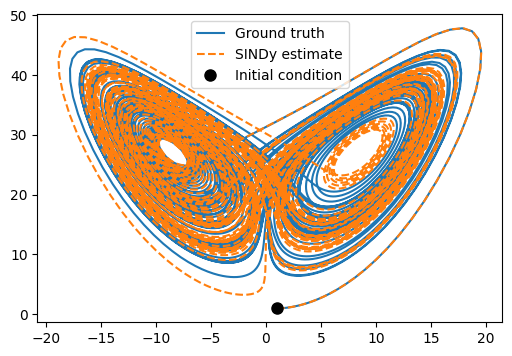

In [18]:
plt.figure(figsize=(6, 4))
plt.plot(x_train[:, 0], x_train[:, 2], label='Ground truth')
plt.plot(x_sim[:, 0], x_sim[:, 2], '--', label='SINDy estimate')
plt.plot(x_train[0, 0], x_train[0, 2], "ko", label="Initial condition", markersize=8)
plt.legend()
plt.draw()
plt.show()

In [19]:
def plot_dimension(dim, name):
    fig = plt.figure(figsize=(9,2))
    ax = fig.gca()
    ax.plot(time_steps, x_train[:, dim])
    ax.plot(time_steps, x_sim[:, dim], "--")
    plt.xlabel("time")
    plt.ylabel(name)


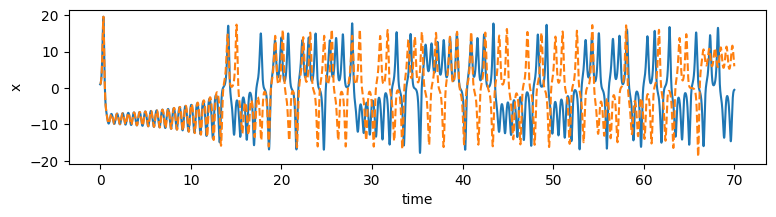

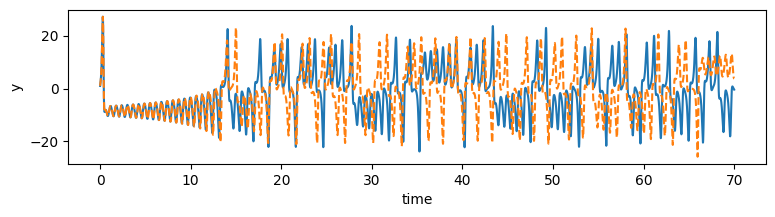

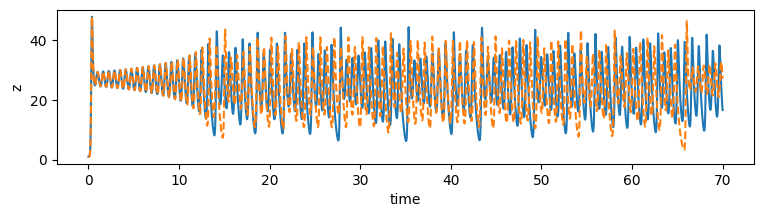

In [20]:
plot_dimension(0, 'x')
plot_dimension(1, 'y')
plot_dimension(2, 'z')

In [98]:
a = reservoir_computing(x_train, sparsity=0.3, reservoir_size=1500, regularization=0.001)

In [99]:
a.save_weight('test')
#a.prerun(100)

In [81]:
print(a.weights_hidden)
#sparse.csc_matrix(a.weights_hidden)

  (1368, 493)	0.0005225859243106363
  (433, 1161)	0.00016085408115729124
  (1465, 1151)	0.0011217815397037935
  (721, 461)	0.001746945845596707
  (1006, 833)	0.00129810706892393
  (887, 627)	0.0004426468768257384
  (577, 1358)	3.140938970159328e-05
  (555, 208)	0.000935623011678104
  (671, 629)	0.00047177849800147833
  (1377, 642)	0.0025633986643629155
  (561, 980)	0.0022491987808983083
  (11, 562)	0.001629928660324254
  (693, 758)	0.0016059306063257186
  (202, 327)	0.002534099551351802
  (675, 268)	0.002318637562328429
  (1028, 1004)	0.0009579086684898177
  (958, 1067)	0.0006153842737514506
  (1195, 33)	0.00020775655176552682
  (25, 1298)	0.001731014455735187
  (327, 1077)	0.0008981427282056114
  (989, 291)	0.002388288071482436
  (1437, 1291)	0.0004220758286892495
  (732, 453)	0.0015565716277803274
  (1246, 726)	0.00029518162541566483
  (549, 697)	0.0012110174731619105
  :	:
  (817, 325)	0.0006540237895686084
  (1076, 619)	0.0004026601728903731
  (1164, 1045)	0.0019883763392756723
  (

In [74]:
x_sim = a.predict(60, 4000)
x_sim.shape

(4000, 3, 1)

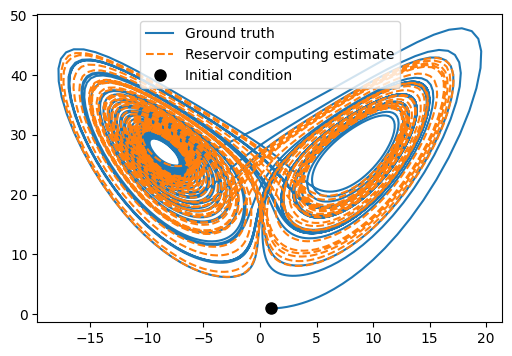

In [75]:
plt.figure(figsize=(6, 4))
plt.plot(x_train[:4000, 0], x_train[:4000, 2], label="Ground truth")
plt.plot(x_sim[:, 0], x_sim[:, 2],'--', label="Reservoir computing estimate")
plt.plot(x_train[0, 0], x_train[0, 2], "ko", label="Initial condition", markersize=8)

plt.legend()
plt.show()

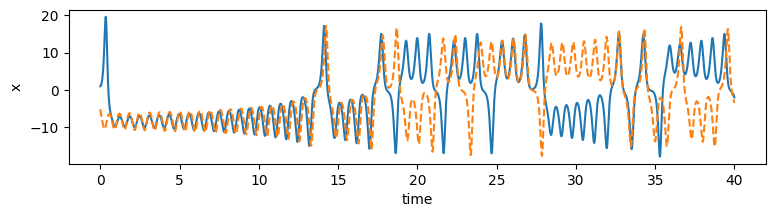

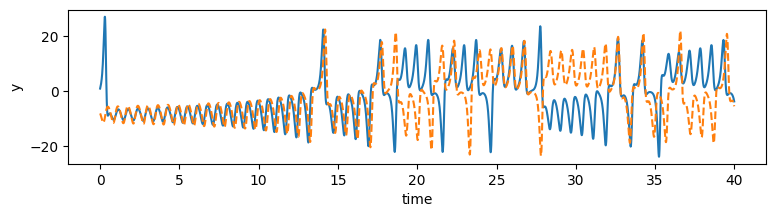

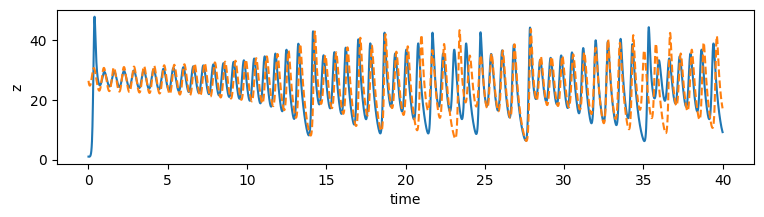

In [77]:
plot_dimension(0, 'x')
plot_dimension(1, 'y')
plot_dimension(2, 'z')

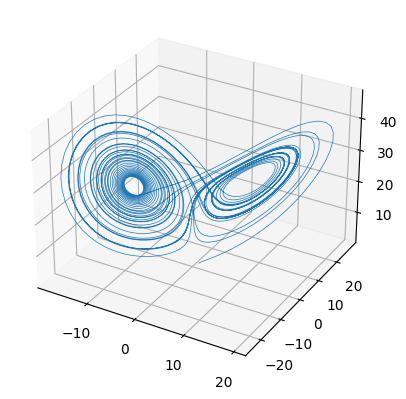

In [45]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(x_train[:4000, 0], x_train[:4000, 1], x_train[:4000, 2].T, lw=0.5)

FileNotFoundError: [Errno 2] No such file or directory: 'abc.txt'